In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from toolbox import read_pixel_data, one_hot_encoding, draw_loss_n_save
from config import *



In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

tf.keras.backend.set_image_data_format('channels_first')

## Load Data

In [3]:
train_X, train_y = read_pixel_data(part='train')
val_X, val_y = read_pixel_data(part='val')
test_X, test_y = read_pixel_data(part='test')
print(f"{'train_X shape':<15}: {train_X.shape}")
print(f"{'train_y shape':<15}: {train_y.shape}")
print(f"{'val_X shape':<15}: {val_X.shape}")
print(f"{'val_y shape':<15}: {val_y.shape}")
print(f"{'test_X shape':<15}: {test_X.shape}")
print(f"{'test_y shape':<15}: {test_y.shape}")

100%|██████████| 450/450 [00:00<00:00, 17319.59it/s]

train_X shape  : (63325, 3, 32, 32)
train_y shape  : (63325,)
val_X shape    : (450, 3, 32, 32)
val_y shape    : (450,)
test_X shape   : (450, 3, 32, 32)
test_y shape   : (450,)


## Preprocessing Data

In [4]:
train_X = train_X / float(255)
val_X = val_X / float(255)
test_X = test_X / float(255)
train_X -= np.mean(train_X)
val_X -= np.mean(val_X)
test_X -= np.mean(test_X)

In [5]:
train_y = one_hot_encoding(train_y, 50)
val_y = one_hot_encoding(val_y, 50)
test_y = one_hot_encoding(test_y, 50)

## Model

In [6]:
lenet = Sequential([
    layers.Conv2D(6, kernel_size=5, input_shape=train_X.shape[1:], activation='sigmoid'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=5, activation='sigmoid'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation='sigmoid'),
    layers.Dense(84, activation='sigmoid'),
    layers.Dense(50, activation='sigmoid'),
])

optimizer = Adam(learning_rate=LEARNING_RATE)
lenet.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])
mckpt = ModelCheckpoint('./checkpoint/', save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
rdlp = ReduceLROnPlateau(monitor='val_loss', mode='min', min_lr=1e-5)
history = lenet.fit(
    train_X, train_y, 
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    shuffle=True, workers=30,
    validation_data=(val_X, val_y),
    callbacks=[mckpt, rdlp])



Epoch 1/150
248/248 [==============================] - 7s 7ms/step - loss: 3.8999 - categorical_accuracy: 0.0272 - val_loss: 3.8344 - val_categorical_accuracy: 0.0444 - lr: 0.0010
Epoch 2/150
248/248 [==============================] - 2s 7ms/step - loss: 3.7494 - categorical_accuracy: 0.0514 - val_loss: 3.6805 - val_categorical_accuracy: 0.0667 - lr: 0.0010
Epoch 3/150
248/248 [==============================] - 2s 7ms/step - loss: 3.6268 - categorical_accuracy: 0.0719 - val_loss: 3.5748 - val_categorical_accuracy: 0.0889 - lr: 0.0010
Epoch 4/150
248/248 [==============================] - 2s 7ms/step - loss: 3.5471 - categorical_accuracy: 0.0848 - val_loss: 3.5247 - val_categorical_accuracy: 0.1067 - lr: 0.0010
Epoch 5/150
248/248 [==============================] - 2s 7ms/step - loss: 3.4933 - categorical_accuracy: 0.0930 - val_loss: 3.4638 - val_categorical_accuracy: 0.1044 - lr: 0.0010
Epoch 6/150
248/248 [==============================] - 2s 7ms/step - loss: 3.4287 - categorical_accu

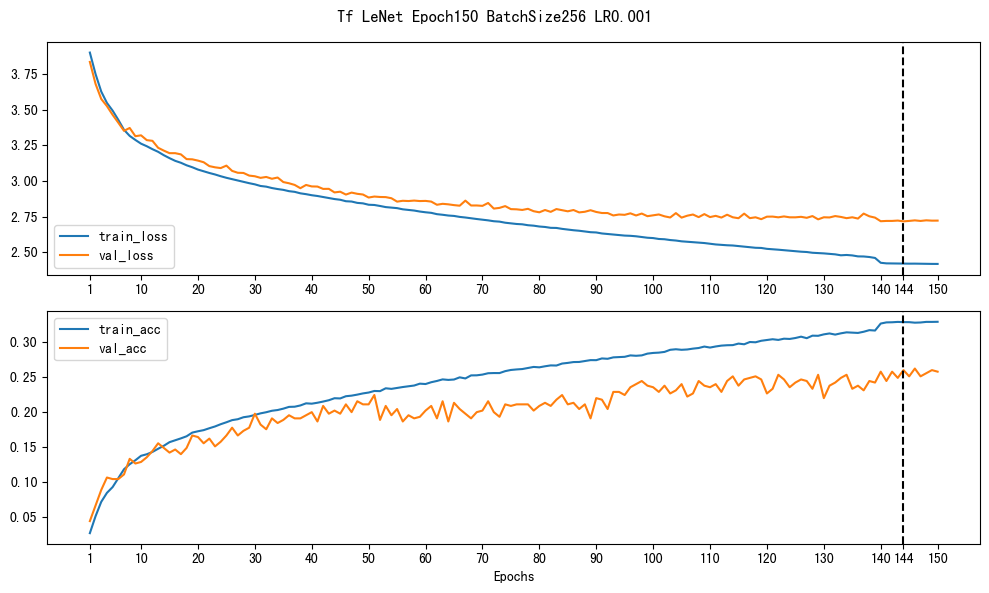

In [7]:
dict_hyper = {'v': 'TF', 'e': EPOCHS, 'b': BATCH_SIZE, 'lr': LEARNING_RATE}

ls_result = zip(history.history['loss'], history.history['categorical_accuracy'], 
                history.history['val_loss'], history.history['val_categorical_accuracy'])

draw_loss_n_save(ls_result, dict_hyper)

## Test

In [8]:
test_loss, test_acc = lenet.evaluate(test_X, test_y)
print(f"{'Test Loss':<12}: {round(test_loss, 4)}")
print(f"{'Test Acc':<12}: {round(test_acc, 4)}")

15/15 [==============================] - 0s 5ms/step - loss: 2.8115 - categorical_accuracy: 0.2556
Test Loss   : 2.8115
Test Acc    : 0.2556


In [11]:
pd.DataFrame(ls_result, columns=['train_loss', 'train_acc', 'val_loss', 'val_acc']).reset_index(names='epoch')\
    .to_csv(f"{dict_hyper['v'].capitalize()}_LeNet_Epoch{dict_hyper['e']}_BatchSize{dict_hyper['b']}_LR{dict_hyper['lr']}.csv", index=False)